In [1]:
import pandas as pd
import wrangle as w
import explore as e
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from functools import reduce

import matplotlib.pyplot as plt

# importing necessary libraries
import pandas as pd
import numpy as np


from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

## Recreate model data from model.ipynb notebook

In [2]:
# acquire dataframe
df = w.get_perpetrator_df()

# create production dataframe based on the target variables
production_df = df[df['gname'].str.contains('Unknown')==True]

# create target variable dataframe
df1 = df[df['gname'].str.contains('Unknown')==False]

# drop columns from the dataframe that arent relevant in the predictor
model_df = df1.drop(columns=['event_id',
             'month',
             'day',
             'region',
             'latitude',
             'longitude',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])


production_df = production_df.drop(columns=['event_id',
             'month',
             'day',
             'region',
             'latitude',
             'longitude',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])

# change year to object type
model_df.year = model_df.year.astype('str')
production_df.year = production_df.year.astype('str')

data = model_df


In [3]:
production_df.shape, data.shape

((27630, 10), (13281, 10))

### Scaling

In [4]:
# create a dataframe for the gname target variable
gnames = pd.DataFrame(data.gname)

# create nkill df
nkills = pd.DataFrame(data.nkill)

# scale nkill
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(nkills)
nkills = pd.DataFrame(scaler.transform(nkills))
nkills = nkills.rename(columns={0:'nkill'})

In [5]:
data.shape[0], gnames.shape[0], nkills.shape[0]

(13281, 13281, 13281)

### Dummy df

In [6]:
# encode variables
dummy_df = pd.get_dummies(model_df[['country',
                                    'provstate',
                                    'city',
                                    'suicide',
                                    'attack_type', 
                                    'targtype',  
                                    'weaptype',
                                    'year']], dummy_na=False, drop_first=[True, True])

In [7]:
dummy_df = dummy_df.reset_index(drop=True)
dummy_df.index

RangeIndex(start=0, stop=13281, step=1)

In [8]:
gnames = gnames.reset_index(drop=True)
gnames.index

RangeIndex(start=0, stop=13281, step=1)

In [9]:
# add target to dataframe
dummy_df = pd.concat([dummy_df, gnames, nkills], axis=1)

In [10]:
dummy_df.shape

(13281, 3451)

---

### Production Data Block

In [11]:
# size difference between prod df and og model df

In [12]:
production_df.head(1)

,year,country,provstate,city,suicide,attack_type,targtype,gname,weaptype,nkill
date,,,,,,,,,,
2001-01-01,2001,turkey,Istanbul,Istanbul,0,Bombing/Explosion,Private Citizens & Property,Unknown,Explosives,0.0


In [13]:
# create a dataframe for the gname target variable
gnames2 = pd.DataFrame(production_df.gname)

# create nkill df
nkills2 = pd.DataFrame(production_df.nkill)

scaler2 = MinMaxScaler()

scaler2.fit(nkills2)
nkills2 = nkills2.rename(columns={0:'nkill'})

In [14]:
# encode variables
dummy_df2 = pd.get_dummies(production_df[['country',
                                    'provstate',
                                    'city',
                                    'suicide',
                                    'attack_type', 
                                    'targtype',  
                                    'weaptype',
                                    'year']], dummy_na=False, drop_first=[True, True])

In [15]:
gnames2 = gnames2.reset_index(drop=True)
gnames2.index

RangeIndex(start=0, stop=27630, step=1)

In [16]:
dummy_df2 = dummy_df2.reset_index(drop=True)
dummy_df2.index

RangeIndex(start=0, stop=27630, step=1)

In [17]:
nkills2 = nkills2.reset_index(drop=True)
nkills2.index

RangeIndex(start=0, stop=27630, step=1)

In [18]:
gnames2.shape, nkills2.shape, dummy_df2.shape

((27630, 1), (27630, 1), (27630, 4560))

In [19]:
# add target to dataframe
dummy_df2 = pd.concat([dummy_df2, gnames2, nkills2], axis=1)

### TTS

#### Prod DF Size

In [26]:
#X_train2= train2.drop(columns=['gname'])
#y_train2 = train2.gname

#X_validate2 = validate2.drop(columns=['gname'])
#y_validate2 = validate2.gname

X_test2 = dummy_df2.drop(columns=['gname'])
y_test2 = dummy_df2.gname

In [27]:
X_test2.shape, y_test2.shape

((27630, 4561), (27630,))

#### OG DF Size

In [28]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.27, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.35, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [29]:
# split into train, validate, test
train, validate, test = train_validate_test_split(dummy_df, target='gname', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train= train.drop(columns=['gname'])
y_train = train.gname

X_validate = validate.drop(columns=['gname'])
y_validate = validate.gname

X_test = test.drop(columns=['gname'])
y_test = test.gname

In [30]:
X_train.shape, X_validate.shape, X_test.shape

((6301, 3450), (3394, 3450), (3586, 3450))

---

### Create Model

In [46]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=4, random_state=123)

# model.fit(X, y)

clf = clf.fit(X_train, y_train)

# make prediction on train obeservations

y_pred = clf.predict(X_train)

# y_pred_proba = clf.predict_proba(X_train2)

# Eval model
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.89


In [49]:
pd.DataFrame(y_pred)

,0
0,Islamic State of Iraq and the Levant (ISIL)
1,Islamic State of Iraq and the Levant (ISIL)
2,Taliban
3,Kurdistan Workers' Party (PKK)
4,Taliban
...,...
6296,Islamic State of Iraq and the Levant (ISIL)
6297,Taliban
6298,Al-Shabaab
6299,Al-Shabaab


In [32]:
metrics = []
for i in range(1, 15):
    tree = DecisionTreeClassifier(max_depth=i, random_state=17)
    tree = tree.fit(X_train, y_train)
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
dt_df = pd.DataFrame(metrics)
dt_df["difference"] = dt_df.train_accuracy - dt_df.validate_accuracy
dt_df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.607205,0.606364,0.000841
1,2,0.745437,0.746022,-0.000585
2,3,0.820187,0.819976,0.000211
3,4,0.887002,0.886859,0.000143
4,5,0.931598,0.930760,0.000838
5,6,0.959372,0.957572,0.001799
6,7,0.965402,0.960224,0.005178
7,8,0.967942,0.959929,0.008012
8,9,0.972703,0.959929,0.012773
9,10,0.976036,0.964054,0.011981


In [35]:
y_pred = logit.predict(X_test)

NameError: name 'logit' is not defined

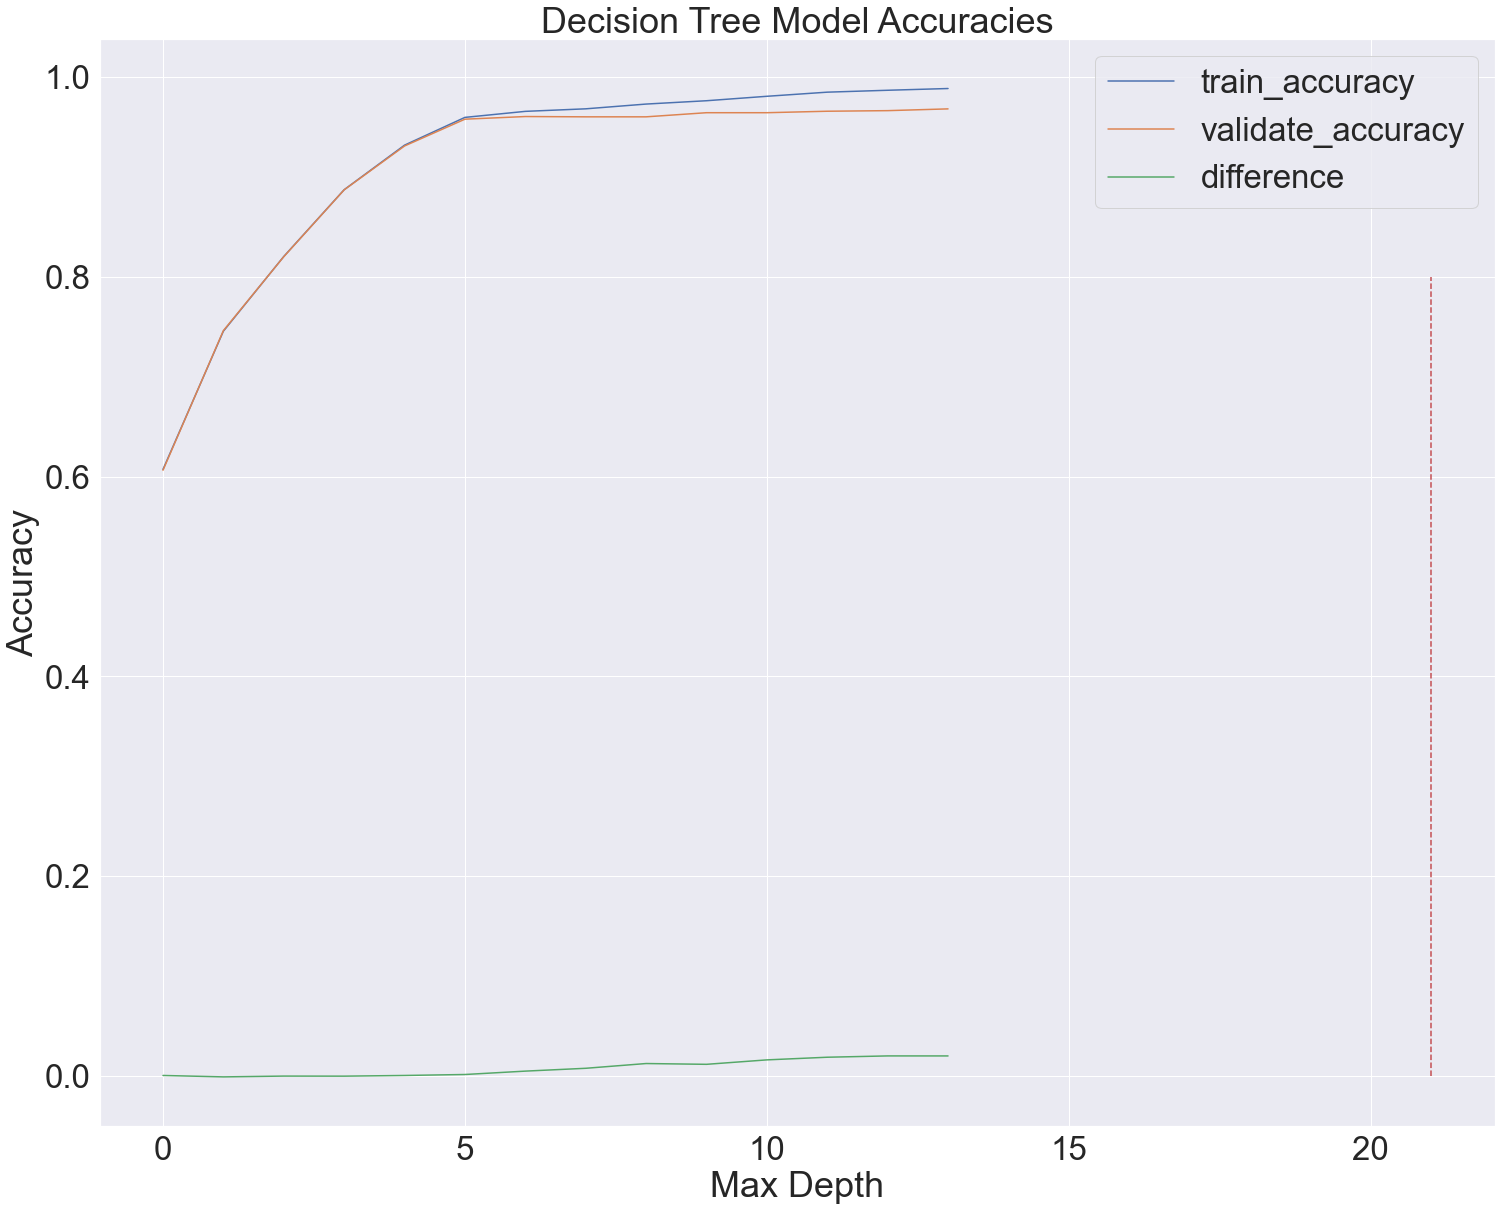

In [33]:
plt.rcParams['figure.figsize'] = [25, 20]
sns.set(font_scale = 3)
dt_df[['train_accuracy', 'validate_accuracy', 'difference' ]].plot()
plt.title("Decision Tree Model Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.vlines(x=[21], ymin=0, ymax=.8, colors='r', linestyles='dashed')
plt.show()

In [34]:
tree = DecisionTreeClassifier(max_depth=14, random_state=123)

tree = tree.fit(X_train, y_train)

tree.score(X_test, y_test)

0.9662576687116564